# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib
import logging
from itertools import product
import networkx as nx

logging.basicConfig(level=logging.INFO)

# Load dataset

In [ ]:
df = pd.read_csv('data/Cleaned_Student_performance_data.csv')
logging.info(f"Dataset shape: {df.shape}")

INFO:root:Dataset shape: (2392, 15)


# Analyze dataset

INFO:root:Descriptive statistics:
INFO:root:         StudentID          Age       Gender    Ethnicity  ParentalEducation  \
count  2392.000000  2392.000000  2392.000000  2392.000000        2392.000000   
mean   2196.500000    16.468645     0.510870     0.877508           1.746237   
std     690.655244     1.123798     0.499986     1.028476           1.000411   
min    1001.000000    15.000000     0.000000     0.000000           0.000000   
25%    1598.750000    15.000000     0.000000     0.000000           1.000000   
50%    2196.500000    16.000000     1.000000     0.000000           2.000000   
75%    2794.250000    17.000000     1.000000     2.000000           2.000000   
max    3392.000000    18.000000     1.000000     3.000000           4.000000   

       StudyTimeWeekly     Absences     Tutoring  ParentalSupport  \
count      2392.000000  2392.000000  2392.000000      2392.000000   
mean          9.772199    14.541388     0.301421         2.122074   
std           5.652105     8

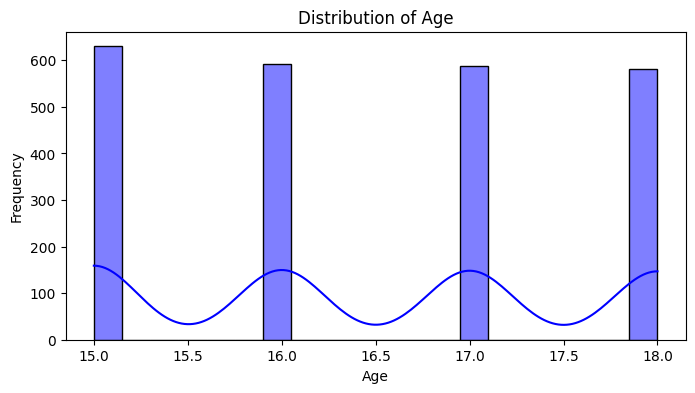

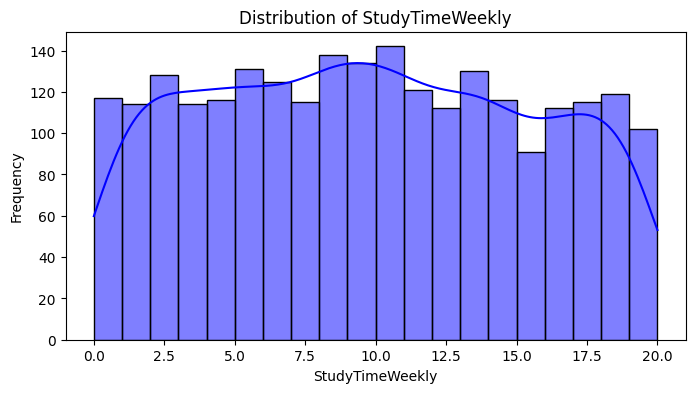

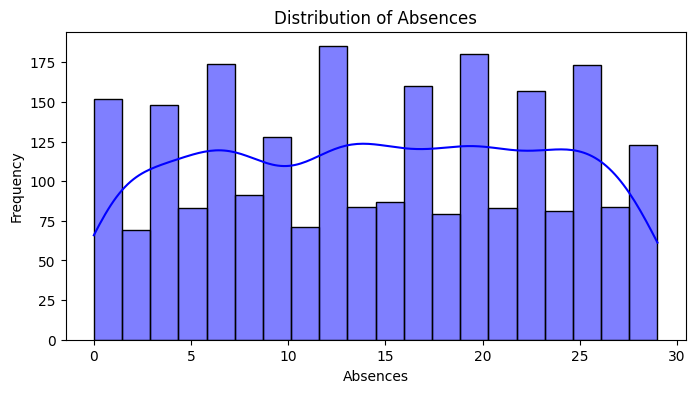

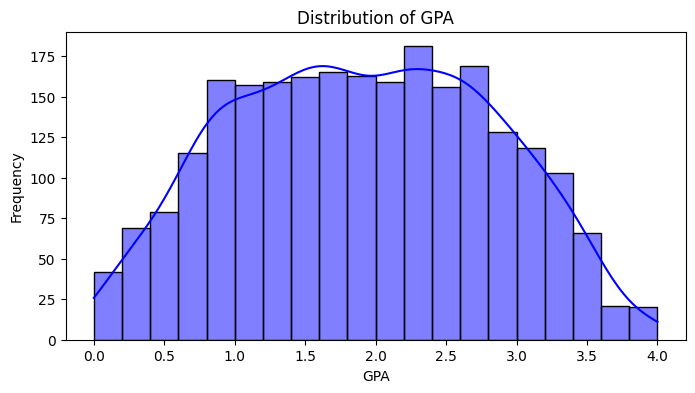

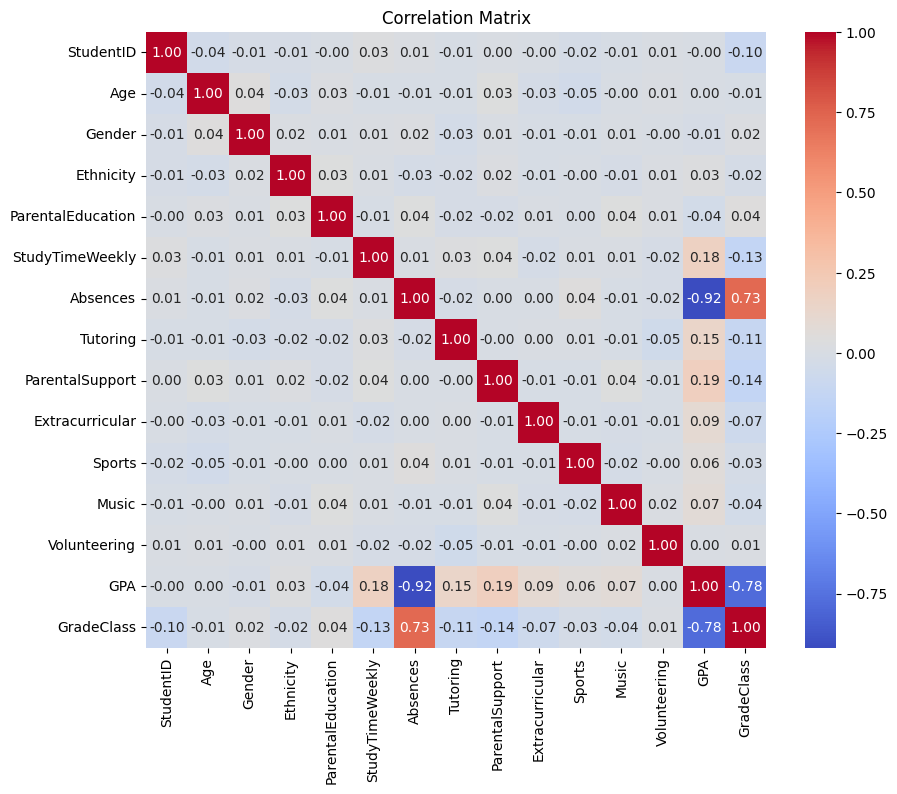

In [ ]:
# Descriptive statistics
logging.info("Descriptive statistics:")
logging.info(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
logging.info(f"Missing values:\n{missing_values}")

# Handle missing values (if any)
df.fillna(df.median(), inplace=True)  # Replace missing values with median

# Visualize distributions of numerical features
numerical_cols = ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=20, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze correlations
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Discretize continuous features

In [ ]:
gpa_bins   = [0, 1.0, 2.0, 3.0, 4.0]
gpa_labels = ['VeryLow', 'Low', 'Medium', 'High']
df['GPA_bin'] = pd.cut(df['GPA'], bins=gpa_bins, labels=gpa_labels, include_lowest=True)

study_bins   = [0, 5, 10, 15, 20, np.inf]
study_labels = ['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
df['Study_bin'] = pd.cut(df['StudyTimeWeekly'], bins=study_bins, labels=study_labels, include_lowest=True)

abs_bins   = [0, 5, 10, 15, 20, np.inf]
abs_labels = ['None', 'Few', 'Moderate', 'High', 'VeryHigh']
df['Absences_bin'] = pd.cut(df['Absences'], bins=abs_bins, labels=abs_labels, include_lowest=True)

# Encode categorical variables

In [ ]:
categorical_cols = [
    'Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 
    'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Study_bin', 'Absences_bin', 'GPA_bin', 'GradeClass'
]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature selection and data split

In [ ]:
features = [
    'ParentalEducation', 'Sports', 'Music', 'Volunteering', 'Extracurricular',  
    'Tutoring', 'Absences', 'StudyTimeWeekly', 'ParentalSupport'
]
target_gpa   = 'GPA'
target_class = 'GradeClass'

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[target_class]
)

# Define Bayesian Network structure

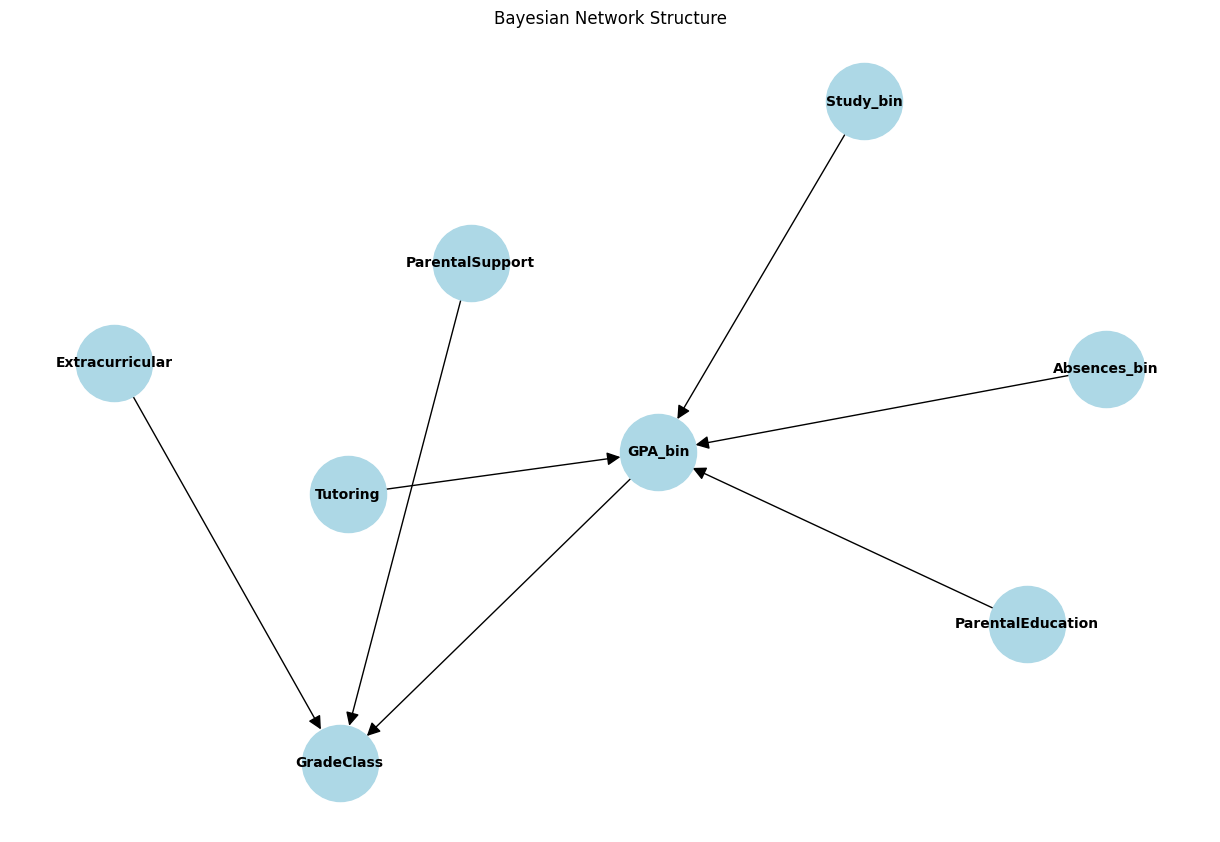

In [ ]:
parents = {
    'ParentalEducation': [],
    'Sports': [],
    'Music': [],
    'Volunteering': [],
    'Extracurricular': ['Sports', 'Music', 'Volunteering'],
    'Tutoring': ['ParentalEducation'],
    'Absences': [],
    'StudyTimeWeekly': [],
    'ParentalSupport': [],
    'GPA': ['ParentalSupport', 'Absences', 'StudyTimeWeekly', 'Tutoring', 'Extracurricular'],
    'GradeClass': ['GPA']
}

# Visualize Bayesian Network structure
def visualize_bayesian_network(parents):
    G = nx.DiGraph()
    for child, pars in parents.items():
        for parent in pars:
            G.add_edge(parent, child)
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="lightblue")
    
    # Highlight target nodes
    target_nodes = ['GPA', 'GradeClass']
    nx.draw_networkx_nodes(G, pos, nodelist=target_nodes, node_size=3500, 
                           node_color="lightgreen", edgecolors='green', linewidths=2)
    
    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    
    plt.title("Bayesian Network Structure Based on Specified Parent Relationships")
    plt.axis('off')
    plt.show()

visualize_bayesian_network(parents)

# Compute Conditional Probability Tables (CPTs)

In [22]:
CPT = {}

# Hyperparameters
laplace_smoothing = 1  # Smoothing factor
min_data_threshold = 5  # Minimum data points required for a combination

for node, pars in parents.items():
    if not pars:
        # For nodes without parents, calculate prior probabilities
        CPT[node] = train_df[node].value_counts(normalize=True).to_dict()
    else:
        # For nodes with parents, calculate conditional probabilities
        parent_values = [train_df[p].unique() for p in pars]
        combinations = list(product(*parent_values))
        table = {}
        classes = train_df[node].unique()

        for combo in combinations:
            # Create a mask for the current combination of parent values
            mask = np.ones(len(train_df), dtype=bool)
            for p, v in zip(pars, combo):
                mask &= (train_df[p] == v)
            subset = train_df[mask]

            # Check if the subset has enough data points
            if len(subset) < min_data_threshold:
                logging.warning(f"Combination {combo} for node {node} has insufficient data ({len(subset)} rows).")
                continue

            # Calculate counts and probabilities with Laplace smoothing
            counts = subset[node].value_counts()
            total = counts.sum()
            probs = {
                c: (counts.get(c, 0) + laplace_smoothing) / (total + laplace_smoothing * len(classes))
                for c in classes
            }
            table[tuple(int(x) for x in combo)] = probs

        CPT[node] = table

# Log the size of each CPT
for node, table in CPT.items():
    logging.info(f"CPT for node {node} contains {len(table)} entries.")

INFO:root:CPT for node Gender contains 2 entries.
INFO:root:CPT for node Ethnicity contains 4 entries.
INFO:root:CPT for node ParentalEducation contains 5 entries.
INFO:root:CPT for node Tutoring contains 2 entries.
INFO:root:CPT for node ParentalSupport contains 5 entries.
INFO:root:CPT for node Extracurricular contains 2 entries.
INFO:root:CPT for node Study_bin contains 4 entries.
INFO:root:CPT for node Absences_bin contains 5 entries.
INFO:root:CPT for node GPA_bin contains 125 entries.
INFO:root:CPT for node GradeClass contains 38 entries.


# Save model to .pkl

In [23]:
joblib.dump({
    'CPT': CPT,
    'parents': parents,
    'label_encoders': label_encoders,
    'features': features,
    'target_gpa': target_gpa,
    'target_class': target_class
}, 'models/bayesian_model.pkl')

# Save mean GPA per GPA_bin (for numeric estimate)
mean_gpa = train_df.groupby('GPA_bin')['GPA'].mean().to_dict()
joblib.dump(mean_gpa, 'models/mean_gpa.pkl')

logging.info("Model and mean GPA saved successfully to bayesian_model.pkl and mean_gpa.pkl.")

INFO:root:Model and mean GPA saved successfully to bayesian_model.pkl and mean_gpa.pkl.


# Define prediction functions

In [24]:
def predict_gpa_bin(row):
    key = tuple(row[p] for p in parents['GPA_bin'])
    if key in CPT['GPA_bin']:
        probs = CPT['GPA_bin'][key]
        return max(probs, key=probs.get)
    # Fallback: Use prior distribution
    prior = train_df['GPA_bin'].value_counts(normalize=True).to_dict()
    return max(prior, key=prior.get)

def predict_gradeclass(row):
    key = tuple(row[p] for p in parents['GradeClass'])
    if key in CPT['GradeClass']:
        probs = CPT['GradeClass'][key]
        return max(probs, key=probs.get)
    # Fallback: Use prior distribution
    prior = train_df['GradeClass'].value_counts(normalize=True).to_dict()
    return max(prior, key=prior.get)

# Predict and evaluate

In [25]:
test_df['Predicted_GPA_bin'] = test_df.apply(predict_gpa_bin, axis=1)
test_df['Predicted_GradeClass'] = test_df.apply(predict_gradeclass, axis=1)

# Evaluate GPA predictions
true_gpa = test_df['GPA']
predicted_gpa = test_df['Predicted_GPA_bin'].map(mean_gpa)
mae = mean_absolute_error(true_gpa, predicted_gpa)
rmse = np.sqrt(mean_squared_error(true_gpa, predicted_gpa))
logging.info(f"MAE (GPA): {mae}")
logging.info(f"RMSE (GPA): {rmse}")

# Evaluate GradeClass predictions
accuracy = accuracy_score(test_df['GradeClass'], test_df['Predicted_GradeClass'])
logging.info(f"Accuracy (GradeClass): {accuracy}")

INFO:root:MAE (GPA): 0.4418008535577054
INFO:root:RMSE (GPA): 0.5776360165065325


INFO:root:Accuracy (GradeClass): 0.7494780793319415


# Save evaluation metrics

In [26]:
evaluation_metrics = {
    'MAE_GPA': mae,
    'RMSE_GPA': rmse,
    'Accuracy_GradeClass': accuracy
}
joblib.dump(evaluation_metrics, 'models/evaluation_metrics.pkl')
logging.info("Evaluation metrics saved successfully.")

INFO:root:Evaluation metrics saved successfully.
